## Neural Admixture vs ADMIXTURE for Global Ancestry

What is admixture analysis
Optimization problem Q and F
Difference in algo - EM + Block relaxation vs Encoder Decoder

## Plotting using both to compare output

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import subprocess
import pandas as pd
import os
import shutil

In [2]:
# !pip install neural-admixture
# !pip install --upgrade numpy numba numexpr

In [3]:
PREFIX = "example_data" 
data_dir = "example_data/"
output_dir = "outputs" 
os.makedirs(output_dir, exist_ok=True)
K_values = [3] # running only for K = 3 populations for now

In [4]:
sampleinfo = pd.read_csv(f"{data_dir}{PREFIX}.tsv", sep="\t")
sample_to_pop = dict(zip(list(sampleinfo["Sample name"]), list(sampleinfo["Population code"])))
samples = [line.split()[0] for line in open(f"{data_dir}{PREFIX}.fam", "r").readlines()]
pops = [sample_to_pop.get(item, "NA") for item in samples]

In [5]:
def plot(file_path):
    fig = plt.figure()
    fig.set_size_inches((10, 8))

    plotind = 1

    ax = fig.add_subplot(3, 1, plotind)

    #data = pd.read_csv("outputs/neural_admixture.%s.Q"%K, delim_whitespace=True, header=None)
    data = pd.read_csv(file_path, delim_whitespace=True, header=None)
    cols = list(data.columns)
    data["sample"] = samples
    data["pop"] = pops
    data = data.sort_values(["pop"]+cols)
    data.plot.bar(stacked=True, ax=ax, width=1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    # Only plot label for first sample in each pop
    xticklabels = []
    currpop = ""
    for i in range(data.shape[0]):
        if data["pop"].values[i] == currpop:
            xticklabels.append("")
        else:
            xticklabels.append(data["pop"].values[i])
            currpop = data["pop"].values[i]
    ax.set_xticklabels(xticklabels)

    plotind += 1
    fig.tight_layout()
    

## ADMIXTURE

Running ADMIXTURE for K=3...
Process complete. Plotting...


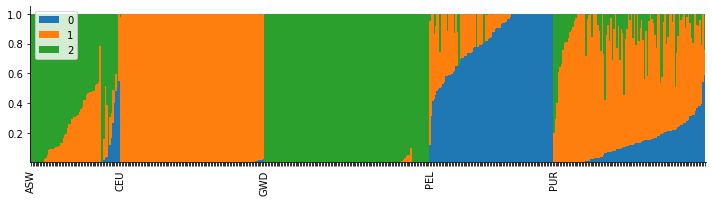

In [6]:
for K in K_values:
    print(f"Running ADMIXTURE for K={K}...")
    # Construct the command to run
    cmd = f"admixture --cv {data_dir}{PREFIX}.bed {K}"
    
    # Execute the command and capture the output
    process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    
    # Decode and print the output to console
#     print(stdout.decode())
    if (stderr):
        print(stderr.decode())
    else:
        print("Process complete. Plotting...")
    
    files = [f"{PREFIX}.{K}.P", f"{PREFIX}.{K}.Q"]
    out_files = [f"admixture.{K}.P", f"admixture.{K}.Q"]
    
    # Move files to output folder
    for old,new in zip(files,out_files):
        if os.path.exists(old):
            shutil.move(old, os.path.join(output_dir, new))
            
    #Plotting the graph for ADMIXTURE
    plot(f"outputs/admixture.{K}.Q")
            
            

## Neural ADMIXTURE

Running Neural ADMIXTURE for K=3...
/home/yshukla/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (
Mapping files:   0%|          | 0/3 [00:00<?, ?it/s]/home/yshukla/.local/lib/python3.9/site-packages/neural_admixture/src/snp_reader.py:55: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  _, _, G = read_plink(str(Path(file).with_suffix("")))
/home/yshukla/.local/lib/python3.9/site-packages/neural_admixture/src/snp_reader.py:55: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  _, _, G = read_plink(str(Path(file).with_suffix("")))
Epoch 19: 100%|██████████| 2/2 [00:14<00:00,  7.50s/it]



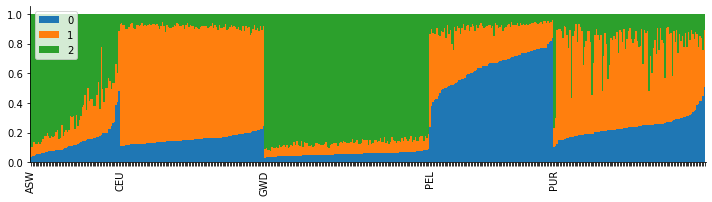

In [7]:
for K in K_values:
    
    print(f"Running Neural ADMIXTURE for K={K}...")
    
    cmd = f"~/.local/bin/neural-admixture train --k {K} --data_path {data_dir}{PREFIX}.bed --save_dir {output_dir} --name neural_admixture --max_epochs 500 --seed 43 --initialization pcarchetypal"
    
    # Execute the command and capture the output
    process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    stdout, stderr = process.communicate()
    
    # Decode and print the output to console
#     print(stdout.decode())
    if stderr:
        print(stderr.decode())
    else:
        print("Process complete. Plotting...")
    
    plot(f"outputs/neural_admixture.{K}.Q")

## Runtime and Memory Comparison

In [ ]:
# Code to calculate memory and runtime!

In [ ]:
# for K in K_values:
#     # Construct the command to run
#     cmd = f"/usr/bin/time -al -p admixture --cv {data_dir}{PREFIX}.bed {K}"
    
#     # Execute the command and capture the output
#     process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#     stdout, stderr = process.communicate()
    
#     # Decode and print the output to console
#     print(stdout.decode())
#     print(stderr.decode())
    
#     files = [f"{PREFIX}.{K}.P", f"{PREFIX}.{K}.Q"]
#     out_files = [f"admixture.{K}.P", f"admixture.{K}.Q"]
    
#     for old,new in zip(files,out_files):
#         if os.path.exists(old):
#             shutil.move(old, os.path.join(output_dir, new))

In [ ]:
# for K in K_values:
#     # Construct the command to run
#     cmd = f"/usr/bin/time -al -p ~/.local/bin/neural-admixture train --k {K} --data_path {data_dir}{PREFIX}.bed --save_dir {output_dir} --name neural_admixture --max_epochs 500 --seed 43 --initialization pcarchetypal"
    
#     # Execute the command and capture the output
#     process = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
#     stdout, stderr = process.communicate()
    
#     # Decode and print the output to console
#     print(stdout.decode())
#     print(stderr.decode())